In [ ]:
# Xinguo Zhang

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from pandas import read_csv, unique 
from scipy.interpolate import interp1d 
from scipy.stats import mode 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 
from tensorflow import stack 
from keras.models import Sequential 
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation 
from keras.layers import Conv1D, LSTM 
from keras.layers import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping 
import matplotlib.pyplot as plt 
%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import numpy as np
import tensorflow as tf
from keras.layers import Bidirectional, GRU, Dense, Concatenate, Conv1D, GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K

In [2]:

def read_data(filepath):
    df = pd.read_csv(filepath, header=None, names=['id',
                                                   'time',
                                                   'activity',
                                                   'x-axis',
                                                   'y-axis',
                                                   'z-axis'])
    # 去除最后一列的分号，并将其转换为浮点数
    df['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

df = read_data('filtered_data.txt')

label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())

interpolation_fn = interp1d(df['activityEncode'], df['z-axis'], kind='linear')
null_list = df[df['z-axis'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['z-axis'] = df['z-axis'].fillna(value)
df

,id,time,activity,x-axis,y-axis,z-axis,activityEncode
0,1,0.00,Walking,2.038210,10.369094,-1.069652,5
1,1,0.05,Walking,5.502960,8.524008,-1.547342,5
2,1,0.10,Walking,2.136684,10.173450,0.423881,5
3,1,0.15,Walking,-3.069135,7.222617,-1.309227,5
4,1,0.20,Walking,-3.944165,5.354588,-1.743748,5
...,...,...,...,...,...,...,...
1085358,36,1605.15,Standing,-0.919763,9.605943,2.372359,3
1085359,36,1605.20,Standing,-1.207298,9.638048,2.712811,3
1085360,36,1605.25,Standing,-1.463533,7.903360,2.267007,3
1085361,36,1605.30,Standing,-2.066124,8.460453,2.481919,3


In [ ]:
label_encode = LabelEncoder()           #fit_transform对一维数组进行拟合和转换
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())

interpolation_fn = interp1d(df['activityEncode'], df['z-axis'], kind='linear')
null_list = df[df['z-axis'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)#插值
    df['z-axis'] = df['z-axis'].fillna(value)#填充

def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps + 1, step):
        xs = df['x-axis'].values[i:i+time_steps]
        ys = df['y-axis'].values[i:i+time_steps]
        zs = df['z-axis'].values[i:i+time_steps]

        label = df[label_name][i:i+time_steps].value_counts().index[0]
        segments.append(np.array([xs, ys, zs]).T)
        labels.append(label)

    reshaped_segments = np.array(segments, dtype=np.float32)
    labels = np.array(labels)

    reshaped_segments = reshaped_segments.reshape(-1, time_steps, N_FEATURES)

    return reshaped_segments, labels

threshold = 0.15
def signal_decomposition(signal):
    # 使用CEEMDAN进行信号分解
    ceemdan = CEEMDAN()
    imfs = ceemdan(signal)
    # 根据IMFs与噪声的相关性选择保留的IMFs
    filtered_imfs = []
    for i in range(len(imfs)):wo
        correlation = pearsonr(signal, imfs[i])[0]
        if correlation > threshold:
            filtered_imfs.append(imfs[i])
    return filtered_imfs

def signal_denoising(signal):
    # 将 signal 转换为 NumPy 数组
    signal_array = np.array(signal) 
    # 使用双边滤波进行信号去噪
    denoised_signal = denoise_bilateral(signal_array, win_size=5, sigma_color=0.1, sigma_spatial=2)
    return denoised_signal

def preprocess_data(x, y):
    processed_x = []
    for i in range(len(x)):
        signal = x[i].flatten()
        # 信号分解
        imfs = signal_decomposition(signal)
        # 信号去噪
        denoised_signal = signal_denoising(imfs)
        processed_x.append(denoised_signal)
    processed_x = np.array(processed_x)
    return processed_x, y

TIME_PERIOD = 128
STEP_DISTANCE = 64
LABEL = 'activity'
num_classes = 6

train_indices = np.where(df['id'] <= 30)[0]
test_indices = np.where(df['id'] > 30)[0]
x_train, y_train = segments(df.iloc[train_indices], TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test = segments(df.iloc[test_indices], TIME_PERIOD, STEP_DISTANCE, LABEL)

# 预处理训练数据
x_train_processed, y_train_processed = preprocess_data(x_train, y_train)

# 预处理测试数据
x_test_processed, y_test_processed = preprocess_data(x_test, y_test)

# 将类标签转换为独热编码
y_train_onehot = to_categorical(y_train_processed, num_classes)
y_test_onehot = to_categorical(y_test_processed, num_classes)


IndentationError: unexpected indent (1324803017.py, line 69)

In [6]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps + 1, step):
        xs = df['x-axis'].values[i:i+time_steps]
        ys = df['y-axis'].values[i:i+time_steps]
        zs = df['z-axis'].values[i:i+time_steps]

        label = df[label_name][i:i+time_steps].value_counts().index[0]
        segments.append(np.array([xs, ys, zs]).T)
        labels.append(label)

    reshaped_segments = np.array(segments, dtype=np.float32)
    labels = np.array(labels)

    reshaped_segments = reshaped_segments.reshape(-1, time_steps, N_FEATURES)

    return reshaped_segments, labels

TIME_PERIOD = 128
STEP_DISTANCE = 64
LABEL = 'activity'
num_classes = 6

train_indices = np.where(df['id'] <= 30)[0]
test_indices = np.where(df['id'] > 30)[0]
x_train, y_train = segments(df.iloc[train_indices], TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test = segments(df.iloc[test_indices], TIME_PERIOD, STEP_DISTANCE, LABEL)

# 将三维特征降维为二维
pca = PCA(n_components=2)
x_train_2d = pca.fit_transform(x_train.reshape(-1, TIME_PERIOD * 3))

# 使用KMeans进行聚类并重新分配标签
kmeans = KMeans(n_clusters=num_classes)
y_train_pred = kmeans.fit_predict(x_train_2d)
y_train_clustered = y_train_pred

# 更新标签编码和独热编码
label_encoder = LabelEncoder()
label_encoder.fit(y_train_clustered)  # 使用训练集标签进行拟合

y_train_encoded = label_encoder.transform(y_train_clustered)
y_train_onehot = to_categorical(y_train_encoded)

# 标签进行独热编码
y_test_clustered = kmeans.predict(pca.transform(x_test.reshape(-1, TIME_PERIOD * 3)))  # 使用KMeans对测试集进行聚类预测
y_test_encoded = label_encoder.transform(y_test_clustered)
y_test_onehot = to_categorical(y_test_encoded)


In [3]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps + 1, step):
        xs = df['x-axis'].values[i:i+time_steps]
        ys = df['y-axis'].values[i:i+time_steps]
        zs = df['z-axis'].values[i:i+time_steps]

        label = df[label_name][i:i+time_steps].value_counts().index[0]
        segments.append(np.array([xs, ys, zs]).T)
        labels.append(label)

    reshaped_segments = np.array(segments, dtype=np.float32)
    labels = np.array(labels)

    reshaped_segments = reshaped_segments.reshape(-1, time_steps, N_FEATURES)

    return reshaped_segments, labels

TIME_PERIOD = 128
STEP_DISTANCE = 64
LABEL = 'activity'
num_classes = 6

train_indices = np.where(df['id'] <= 30)[0]
test_indices = np.where(df['id'] > 30)[0]
x_train, y_train = segments(df.iloc[train_indices], TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test = segments(df.iloc[test_indices], TIME_PERIOD, STEP_DISTANCE, LABEL)

# 将三维特征降维为二维
pca = PCA(n_components=2)
x_train_2d = pca.fit_transform(x_train.reshape(-1, TIME_PERIOD * 3))

# 使用KMeans进行聚类并重新分配标签
kmeans = KMeans(n_clusters=num_classes)
y_train_pred = kmeans.fit_predict(x_train_2d)
y_train_clustered = y_train_pred

# 更新标签编码和独热编码
label_encoder = LabelEncoder()
label_encoder.fit(y_train_clustered)  # 使用训练集标签进行拟合

y_train_encoded = label_encoder.transform(y_train_clustered)
y_train_onehot = to_categorical(y_train_encoded)

# 标签进行独热编码
y_test_clustered = kmeans.predict(pca.transform(x_test.reshape(-1, TIME_PERIOD * 3)))  # 使用KMeans对测试集进行聚类预测
y_test_encoded = label_encoder.transform(y_test_clustered)
y_test_onehot = to_categorical(y_test_encoded)

# 打印训练集和测试集的形状
print("Training set shape:", x_train.shape)
print("Training labels shape:", y_train_onehot.shape)
print("Testing set shape:", x_test.shape)
print("Testing labels shape:", y_test_onehot.shape)

Training set shape: (13871, 128, 3)
Training labels shape: (13871, 6)
Testing set shape: (3085, 128, 3)
Testing labels shape: (3085, 6)


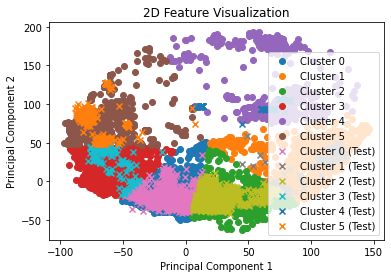

In [5]:
import matplotlib.pyplot as plt

# 绘制训练集数据
for i in range(num_classes):
    plt.scatter(x_train_2d[y_train_clustered == i, 0], x_train_2d[y_train_clustered == i, 1], label="Cluster {}".format(i))

# 绘制测试集数据
for i in range(num_classes):
    plt.scatter(pca.transform(x_test[y_test_clustered == i].reshape(-1, TIME_PERIOD * 3))[:, 0], 
                pca.transform(x_test[y_test_clustered == i].reshape(-1, TIME_PERIOD * 3))[:, 1], 
                label="Cluster {} (Test)".format(i), marker='x')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Feature Visualization')
plt.legend()
plt.show()

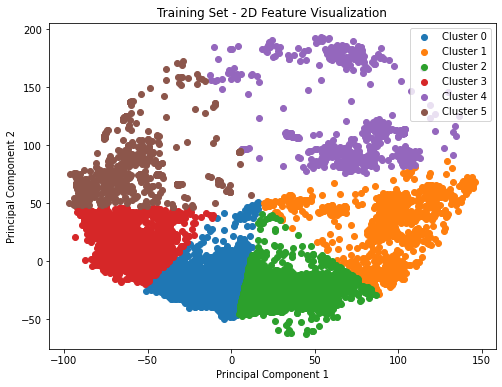

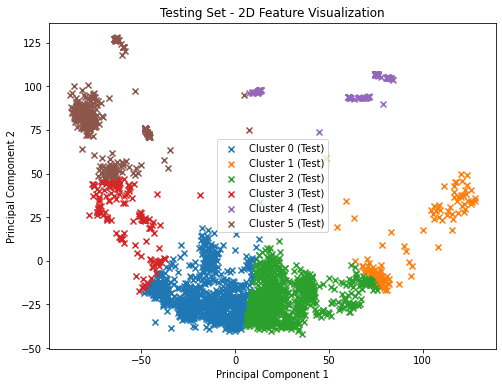

In [6]:
import matplotlib.pyplot as plt

# 绘制训练集数据
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.scatter(x_train_2d[y_train_clustered == i, 0], x_train_2d[y_train_clustered == i, 1], label="Cluster {}".format(i))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Training Set - 2D Feature Visualization')
plt.legend()
plt.show()

# 绘制测试集数据
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.scatter(pca.transform(x_test[y_test_clustered == i].reshape(-1, TIME_PERIOD * 3))[:, 0], 
                pca.transform(x_test[y_test_clustered == i].reshape(-1, TIME_PERIOD * 3))[:, 1], 
                label="Cluster {} (Test)".format(i), marker='x')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Testing Set - 2D Feature Visualization')
plt.legend()
plt.show()

In [ ]:
# 注意力层
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_weights = K.dot(inputs, self.W)
        attention_weights = K.squeeze(attention_weights, axis=-1)
        attention_weights = K.softmax(attention_weights)
        attention_weights = K.expand_dims(attention_weights, axis=-1)
        return attention_weights * inputs

# 构建模型
def build_model(input_shape):
    # 定义BiGRU模块
    bigru_input = tf.keras.Input(shape=input_shape)
    bigru_layer1 = Bidirectional(GRU(units=128, return_sequences=True))(bigru_input)
    bigru_attention = AttentionLayer()(bigru_layer1)
    bigru_layer2 = Bidirectional(GRU(units=64))(bigru_attention)

    # 定义InFCN模块
    infcn_input = tf.keras.Input(shape=input_shape)
    inception1 = inception_module(infcn_input)
    inception2 = inception_module(inception1)
    pooling = GlobalAveragePooling1D()(inception2)

    # 进行模型连接和分类
    concat = Concatenate()([bigru_layer2, pooling])
    output = Dense(num_classes, activation='softmax')(concat)

    # 构建完整模型
    model = Model(inputs=[bigru_input, infcn_input], outputs=output)
    return model

# 定义Inception子模块
def inception_module(x):
    conv1 = Conv1D(filters=256, kernel_size=1, activation='relu')(x)
    conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    conv5 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
    conv1_pool = Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    concat = Concatenate()([conv1, conv3, conv5, conv1_pool])
    return concat

# 构建并编译模型
input_shape = (TIME_PERIOD, 3)
num_classes = 6  # 根据你的实际分类数量进行设置
model = build_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit([x_train, x_train], y_train_onehot, epochs=150, batch_size=16)

In [15]:
# 评估模型
test_loss, test_acc = model.evaluate([x_test, x_test], y_test_onehot, batch_size=32)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

98/98 [==============================] - 3s 21ms/step - loss: 0.2500 - accuracy: 0.9555
Test Loss: 0.25000715255737305, Test Accuracy: 0.9554629921913147


In [14]:
from keras.layers import Bidirectional, GRU
from keras.layers import Concatenate

# 构建模型
def build_model(input_shape):
    # 定义BiGRU模块
    bigru_input = tf.keras.Input(shape=input_shape)
    bigru_layer1 = Bidirectional(GRU(units=128, return_sequences=True))(bigru_input)
    bigru_layer2 = Bidirectional(GRU(units=64))(bigru_layer1)
    bigru_model = tf.keras.Model(inputs=bigru_input, outputs=bigru_layer2)

    # 定义InFCN模块
    infcn_input = tf.keras.Input(shape=input_shape)
    inception1 = inception_module(infcn_input)
    inception2 = inception_module(inception1)
    pooling = GlobalAveragePooling1D()(inception2)
    infcn_model = tf.keras.Model(inputs=infcn_input, outputs=pooling)

    # 进行模型连接和分类
    concat = Concatenate()([bigru_model.output, infcn_model.output])
    output = Dense(num_classes, activation='softmax')(concat)

    # 构建完整模型
    model = tf.keras.Model(inputs=[bigru_model.input, infcn_model.input], outputs=output)
    return model

# 定义Inception子模块
def inception_module(x):
    conv1 = Conv1D(filters=256, kernel_size=1, activation='relu')(x)
    conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    conv5 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
    conv1_pool = Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    concat = Concatenate()([conv1, conv3, conv5, conv1_pool])
    return concat

# 构建并编译模型
input_shape = (TIME_PERIOD, 3)
model = build_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit([x_train, x_train], y_train_onehot, epochs=150, batch_size=128)

Epoch 1/150
107/107 [==============================] - 13s 66ms/step - loss: 0.2643 - accuracy: 0.9225
Epoch 2/150
107/107 [==============================] - 7s 65ms/step - loss: 0.0701 - accuracy: 0.9723
Epoch 3/150
107/107 [==============================] - 7s 66ms/step - loss: 0.0690 - accuracy: 0.9767
Epoch 4/150
107/107 [==============================] - 7s 65ms/step - loss: 0.0690 - accuracy: 0.9738
Epoch 5/150
107/107 [==============================] - 7s 64ms/step - loss: 0.0608 - accuracy: 0.9747
Epoch 6/150
107/107 [==============================] - 7s 65ms/step - loss: 0.0575 - accuracy: 0.9760
Epoch 7/150
107/107 [==============================] - 7s 64ms/step - loss: 0.0624 - accuracy: 0.9768
Epoch 8/150
107/107 [==============================] - 7s 64ms/step - loss: 0.0505 - accuracy: 0.9809
Epoch 9/150
107/107 [==============================] - 7s 64ms/step - loss: 0.0499 - accuracy: 0.9796
Epoch 10/150
107/107 [==============================] - 7s 64ms/step - loss: 0.04

In [15]:
# 评估模型
test_loss, test_acc = model.evaluate([x_test, x_test], y_test_onehot, batch_size=128)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

28/28 [==============================] - 2s 27ms/step - loss: 0.1791 - accuracy: 0.9485
Test Loss: 0.17910383641719818, Test Accuracy: 0.948535680770874


In [9]:
from keras.layers import Bidirectional, GRU
from keras.layers import Concatenate

# 构建模型
def build_model(input_shape):
    # 定义BiGRU模块
    bigru_input = tf.keras.Input(shape=input_shape)
    bigru_layer1 = Bidirectional(GRU(units=128, return_sequences=True))(bigru_input)
    bigru_layer2 = Bidirectional(GRU(units=64))(bigru_layer1)
    bigru_model = tf.keras.Model(inputs=bigru_input, outputs=bigru_layer2)

    # 定义InFCN模块
    infcn_input = tf.keras.Input(shape=input_shape)
    inception1 = inception_module(infcn_input)
    inception2 = inception_module(inception1)
    pooling = GlobalAveragePooling1D()(inception2)
    infcn_model = tf.keras.Model(inputs=infcn_input, outputs=pooling)

    # 进行模型连接和分类
    concat = Concatenate()([bigru_model.output, infcn_model.output])
    output = Dense(num_classes, activation='softmax')(concat)

    # 构建完整模型
    model = tf.keras.Model(inputs=[bigru_model.input, infcn_model.input], outputs=output)
    return model

# 定义Inception子模块
def inception_module(x):
    conv1 = Conv1D(filters=256, kernel_size=1, activation='relu')(x)
    conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    conv5 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
    conv1_pool = Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    concat = Concatenate()([conv1, conv3, conv5, conv1_pool])
    return concat

# 构建并编译模型
input_shape = (TIME_PERIOD, 3)
model = build_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit([x_train, x_train], y_train_onehot, epochs=150, batch_size=64)

Epoch 1/150
214/214 [==============================] - 17s 51ms/step - loss: 0.2118 - accuracy: 0.9293
Epoch 2/150
214/214 [==============================] - 11s 50ms/step - loss: 0.0840 - accuracy: 0.9676
Epoch 3/150
214/214 [==============================] - 11s 49ms/step - loss: 0.0854 - accuracy: 0.9696
Epoch 4/150
214/214 [==============================] - 10s 48ms/step - loss: 0.0857 - accuracy: 0.9692
Epoch 5/150
214/214 [==============================] - 11s 50ms/step - loss: 0.0756 - accuracy: 0.9714
Epoch 6/150
214/214 [==============================] - 11s 50ms/step - loss: 0.0638 - accuracy: 0.9773
Epoch 7/150
214/214 [==============================] - 11s 50ms/step - loss: 0.0652 - accuracy: 0.9757
Epoch 8/150
214/214 [==============================] - 11s 51ms/step - loss: 0.0522 - accuracy: 0.9809
Epoch 9/150
214/214 [==============================] - 11s 50ms/step - loss: 0.0540 - accuracy: 0.9795
Epoch 10/150
214/214 [==============================] - 11s 50ms/step - l

In [11]:
# 评估模型
test_loss, test_acc = model.evaluate([x_test, x_test], y_test_onehot, batch_size=64)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

55/55 [==============================] - 1s 24ms/step - loss: 0.2203 - accuracy: 0.9502
Test Loss: 0.22025281190872192, Test Accuracy: 0.9502416849136353


In [5]:
import numpy as np
import tensorflow as tf
from keras.layers import Bidirectional, GRU, Dense, Concatenate, Conv1D, GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K

# 注意力层
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_weights = K.dot(inputs, self.W)
        attention_weights = K.squeeze(attention_weights, axis=-1)
        attention_weights = K.softmax(attention_weights)
        attention_weights = K.expand_dims(attention_weights, axis=-1)
        return attention_weights * inputs

# 构建模型
def build_model(input_shape):
    # 定义BiGRU模块
    bigru_input = tf.keras.Input(shape=input_shape)
    bigru_layer1 = Bidirectional(GRU(units=128, return_sequences=True))(bigru_input)
    bigru_attention = AttentionLayer()(bigru_layer1)
    bigru_layer2 = Bidirectional(GRU(units=64))(bigru_attention)

    # 定义InFCN模块
    infcn_input = tf.keras.Input(shape=input_shape)
    inception1 = inception_module(infcn_input)
    inception2 = inception_module(inception1)
    pooling = GlobalAveragePooling1D()(inception2)

    # 进行模型连接和分类
    concat = Concatenate()([bigru_layer2, pooling])
    output = Dense(num_classes, activation='softmax')(concat)

    # 构建完整模型
    model = Model(inputs=[bigru_input, infcn_input], outputs=output)
    return model

# 定义Inception子模块
def inception_module(x):
    conv1 = Conv1D(filters=256, kernel_size=1, activation='relu')(x)
    conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    conv5 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
    conv1_pool = Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    concat = Concatenate()([conv1, conv3, conv5, conv1_pool])
    return concat

# 构建并编译模型
input_shape = (TIME_PERIOD, 3)
num_classes = 6  # 根据你的实际分类数量进行设置
model = build_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit([x_train, x_train], y_train_onehot, epochs=150, batch_size=32)

Epoch 1/150
434/434 [==============================] - 31s 58ms/step - loss: 0.1954 - accuracy: 0.9359
Epoch 2/150
434/434 [==============================] - 25s 57ms/step - loss: 0.1000 - accuracy: 0.9614
Epoch 3/150
434/434 [==============================] - 24s 56ms/step - loss: 0.0936 - accuracy: 0.9659
Epoch 4/150
434/434 [==============================] - 25s 58ms/step - loss: 0.0853 - accuracy: 0.9682
Epoch 5/150
434/434 [==============================] - 25s 57ms/step - loss: 0.0750 - accuracy: 0.9734
Epoch 6/150
434/434 [==============================] - 26s 60ms/step - loss: 0.0784 - accuracy: 0.9720
Epoch 7/150
434/434 [==============================] - 26s 59ms/step - loss: 0.0807 - accuracy: 0.9696
Epoch 8/150
434/434 [==============================] - 26s 60ms/step - loss: 0.0678 - accuracy: 0.9752
Epoch 9/150
434/434 [==============================] - 26s 61ms/step - loss: 0.0620 - accuracy: 0.9778
Epoch 10/150
434/434 [==============================] - 25s 59ms/step - l

In [6]:
# 训练模型
model.evaluate([x_test, x_test], y_test_onehot, batch_size=32)

97/97 [==============================] - 5s 30ms/step - loss: 0.2616 - accuracy: 0.9585


[0.26161977648735046, 0.9585089087486267]